In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt


bold_shift=3
f_resample=1.8
n_partitions=25
by_partitions=False
partition_length=15
activation=''

/home/davidcalhas/anaconda3/envs/gpu_tensor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/davidcalhas/anaconda3/envs/gpu_tensor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/davidcalhas/anaconda3/envs/gpu_tensor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/davidcalhas/a

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
DigMontage is a superset of info. 1 in DigMontage will be ignored. The ignored channels are: {'ECG'}
(51, 926, 6)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
DigMontage is a superset of info. 1 in DigMontage will be ignored. The ignored channels are: {'ECG'}
(102, 926, 6)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
DigMontage is a superset of info. 1 in DigMontage will be ignored. The ignored channels are: {'ECG'}
(1

In [2]:
n_ica_components = 90

eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, 
                                                                by_partitions=by_partitions,
                                                                partition_length=partition_length, 
                                                                f_resample=f_resample,
                                                                roi=0, roi_ica_components=n_ica_components)

n_voxels = bold_train.shape[1]

n_voxels = bold_train.shape[1]
interval_length = bold_train.shape[2]

print("Finished Loading Data")


_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), 
                                                 bold_shift=bold_shift, 
                                                 n_partitions=n_partitions, 
                                                 f_resample=f_resample, 
                                                 roi=0, roi_ica_components=n_ica_components)




Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
DigMontage is a superset of info. 1 in DigMontage will be ignored. The ignored channels are: {'ECG'}
(24, 1159, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
DigMontage is a superset of info. 1 in DigMontage will be ignored. The ignored channels are: {'ECG'}
(48, 1159, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
DigMontage is a superset of info. 1 in DigMontage will be ignored. The ignored channels are: {'ECG'}

In [3]:
min_train = np.amin(bold_train)
min_val = np.amin(bold_val)
min_test = np.amin(bold_test)

max_value = np.amin([min_train, min_val, min_test])

bold_train = bold_train - max_value+0.001
bold_val = bold_val - max_value+0.001
bold_test = bold_test - max_value+0.001

bold_train = np.log(bold_train)
bold_val = np.log(bold_val)
bold_test = np.log(bold_test)

eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')
eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

## Create dataset of missing values 

In [4]:
bold_val = np.delete(bold_val, list(range(8)), axis=0)
def missing_values_data(bold_set, n_voxels=10):

    imp_target = np.copy(bold_set)
    imp_target = imp_target.reshape((int(imp_target.shape[0]*imp_target.shape[1]/n_voxels), n_voxels, imp_target.shape[2], imp_target.shape[3]))

    #randomly remove a voxel
    voxels_index = []
    for i in range(n_voxels):
        voxels_index += [i]

    bold_missing = imp_target.copy()
    for instance in range(len(imp_target)):
        voxel_to_remove = np.random.choice(voxels_index)
        missing_voxel = np.zeros(bold_missing[instance][voxel_to_remove].shape)
        bold_missing[instance][voxel_to_remove] = missing_voxel
    
    return bold_missing, imp_target

bold_missing_train, imp_target_train = missing_values_data(bold_train)
bold_missing_val, imp_target_val = missing_values_data(bold_val)
bold_missing_test, imp_target_test = missing_values_data(bold_test)

In [15]:
p_dropout = 0.0
reg_constant = 0.000

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(1, kernel_size=(3, 3), 
                                 strides=(1, 1), 
                                 kernel_regularizer=tf.keras.regularizers.l1(reg_constant),
                                 bias_regularizer=tf.keras.regularizers.l1(reg_constant),
                                 input_shape=(bold_missing_train.shape[1:])))
model.add(tf.keras.layers.Dropout(p_dropout))
model.add(tf.keras.layers.Conv2D(1, kernel_size=(5, 4), 
                                          strides=(1, 1), 
                                          kernel_regularizer=tf.keras.regularizers.l1(reg_constant),
                                          bias_regularizer=tf.keras.regularizers.l1(reg_constant),
                                          input_shape=(bold_missing_train.shape[1:])))

model.add(tf.keras.layers.Dropout(p_dropout))
model.add(tf.keras.layers.Conv2DTranspose(1, kernel_size=(3, 2), 
                                 strides=(1, 1), 
                                 kernel_regularizer=tf.keras.regularizers.l1(reg_constant),
                                 bias_regularizer=tf.keras.regularizers.l1(reg_constant),
                                 input_shape=(bold_missing_train.shape[1:])))
model.add(tf.keras.layers.Dropout(p_dropout))
model.add(tf.keras.layers.Conv2DTranspose(1, kernel_size=(5, 5), 
                                 strides=(1, 1), 
                                 kernel_regularizer=tf.keras.regularizers.l1(reg_constant),
                                 bias_regularizer=tf.keras.regularizers.l1(reg_constant),
                                 input_shape=(bold_missing_train.shape[1:])))
model.add(tf.keras.layers.Dropout(p_dropout))
model.build(input_shape=(bold_missing_train.shape[1:]))

model.compile(tf.keras.optimizers.Adam(lr=0.0001), loss=losses.get_reconstruction_euclidean_loss)

In [21]:
model.summary()
model.loss = losses.get_reconstruction_log_cosine_loss

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 8, 12, 1)          10        
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 12, 1)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 9, 1)           21        
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 9, 1)           0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 6, 10, 1)          7         
_________________________________________________________________
dropout_10 (Dropout)         (None, 6, 10, 1)          0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 10, 14, 1)        

In [22]:
model.fit(bold_missing_train, y=imp_target_train, validation_data=(bold_missing_val, imp_target_val), epochs=20)

Train on 27816 samples, validate on 4636 samples
Epoch 1/20
27816/27816 [==============================] - 2s 85us/sample - loss: 20.6795 - val_loss: 18.5176
Epoch 2/20
27816/27816 [==============================] - 2s 85us/sample - loss: 20.3316 - val_loss: 18.5767
Epoch 3/20
27816/27816 [==============================] - 2s 85us/sample - loss: 19.9889 - val_loss: 18.6070
Epoch 4/20
27816/27816 [==============================] - 2s 86us/sample - loss: 19.6501 - val_loss: 18.4399
Epoch 5/20
27816/27816 [==============================] - 2s 85us/sample - loss: 19.3149 - val_loss: 18.7528
Epoch 6/20
27816/27816 [==============================] - 2s 86us/sample - loss: 18.9820 - val_loss: 18.7853
Epoch 7/20
27816/27816 [==============================] - 2s 86us/sample - loss: 18.6517 - val_loss: 18.9236
Epoch 8/20
27816/27816 [==============================] - 2s 84us/sample - loss: 18.3236 - val_loss: 18.6139
Epoch 9/20
27816/27816 [==============================] - 2s 87us/sample - loss

## Visualization

In [36]:
train_imputed = model(bold_missing_train).numpy()

<IPython.core.display.Javascript object>


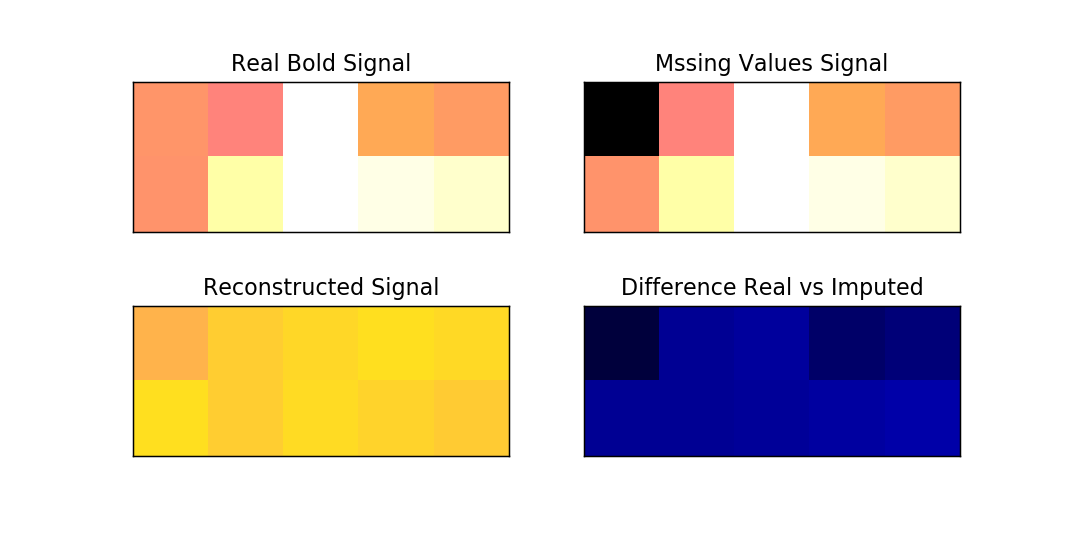

In [39]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numpy.linalg import norm

fig, axs = plt.subplots(2, 2, figsize=(8,4))
for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i][j].set_xticks([], [])
        axs[i][j].set_yticks([],[])

axs[0][0].set_title('Real Bold Signal')
axs[0][1].set_title('Mssing Values Signal')
axs[1][0].set_title('Reconstructed Signal')
axs[1][1].set_title('Difference Real vs Imputed')
    
    
ims1 = []
ims2 = []
ims3 = []
ims4 = []
instance=0

model(bold_val).numpy()

for timestep in range(imp_target_train.shape[2]):
    real_mapping = np.copy(imp_target_train[instance][:, timestep, 0])
    train_imp_mapping = np.copy(train_imputed[instance][:, timestep, 0])
    train_miss_mapping = np.copy(bold_missing_train[instance][:, timestep, 0])
    

    real_mapping.resize((2, 5))
    train_imp_mapping.resize((2, 5))
    train_miss_mapping.resize((2, 5))
    

    vmin = np.amin([np.amin(real_mapping), np.amin(train_imp_mapping), np.amin(train_miss_mapping)])
    vmax = np.amax([np.amax(real_mapping), np.amax(train_imp_mapping), np.amax(train_miss_mapping)])
    
    
    im = axs[0][0].imshow(real_mapping, cmap='gnuplot2', vmin=vmin, vmax=vmax, interpolation='nearest')
    ims1.append([im])
    im = axs[0][1].imshow(train_miss_mapping, cmap='gnuplot2', vmin=vmin, vmax=vmax, interpolation='nearest')
    ims2.append([im])
    im = axs[1][0].imshow(train_imp_mapping, cmap='gnuplot2', vmin=vmin, vmax=vmax, interpolation='nearest')
    ims3.append([im])
    im = axs[1][1].imshow(np.abs(train_imp_mapping-real_mapping), cmap='gnuplot2', vmin=vmin, vmax=vmax, interpolation='nearest')
    ims4.append([im])
    
ani1 = animation.ArtistAnimation(fig, ims1, interval=200, repeat_delay=1000)
ani2 = animation.ArtistAnimation(fig, ims2, interval=200, repeat_delay=1000)
ani3 = animation.ArtistAnimation(fig, ims3, interval=200, repeat_delay=1000)
ani4 = animation.ArtistAnimation(fig, ims4, interval=200, repeat_delay=1000)

plt.show()